# 参数 & 函数

In [2]:
from math import *
import numpy as np
from astropy.constants import G, c, M_sun
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

# 转换为高斯单位制
G = G.cgs.value
c = c.cgs.value
M_sun = M_sun.cgs.value
day = 86400
year = 365*day

# 设置系统参数
pi = np.pi
B = 1e14
R_ns_list = [1.4871e6, 1.2571e6, 1.2029e6, 1.1343e6, 1.04e6]
M_ns = 1.4 * M_sun
M_ej = 5 * M_sun
I_list = [2.0607e45, 1.5699e45, 1.4591e45, 1.3166e45, 1.1583e45]
kappa = 0.1
kappa_gamma = 0.1
type_list = ['I', 'II', 'III']
model_list = ['MS0','BSK21','ENG','APR','WFF1']
t_ni = 8.8 * day
t_co = 111.3 * day
M_ni = 0.1 * M_sun

# 设置初始参数
Omega_0_list = [2 * pi / 1e-3, 2 * pi / 10e-3]
E_int_0 = 1e35
E_sn = 1e51
v_ej_0 = sqrt(2 * (E_int_0 + E_sn) / M_ej)
R_ej_0 = v_ej_0 * 1e-3

# 引力波辐射功率相关参数
epsilon = 1e-3
alpha = 0.1
J_tilde = 0.01635
I_tilde = 0.261

# 计算热光度的函数
def L_bol(type, R_ns, Omega_0, I=1e45):
    """
    Compute bolometric luminosity of an SN.

    :param type: type of radiation mechanism
    :param R_ns: radius of neutron star
    :param Omega_0: initial rotational rate of neutron star
    :param I: moment of inertia
    :return: [t_array, L_bol_array, eta_array]
    """
    beta = B**2 * R_ns**6 / (6 * c**3 * I)
    gamma_e = 32 * G * I * epsilon**2 / (5 * c**5)
    gamma_r = (96 * pi / 15**2) * (4 / 3)**6 * G * M_ns * R_ns**4 * J_tilde**2 / (c**7 * I_tilde) * alpha**2
    def func(t, y):
        """
        The function to put in solve_ivp.

        :param t: time array of the SN explosion
        :param y: list of needed variables, which are Omega, v, E_int, R
        :return: list of dy/dt
        """
        Omega, v_ej, E_int, R_ej = y[0], y[1], y[2], y[3]
        if type == 'I':
            dOmega_dt = - beta * Omega**3
        elif type == 'II':
            dOmega_dt = - beta * Omega**3 - gamma_e * Omega**5
        elif type == 'III':
            dOmega_dt = - beta * Omega**3 - gamma_r * Omega**7
        else:
            raise NotImplementedError

        a_value = 3 * kappa_gamma * M_ej / (4 * pi * R_ej**2)
        eta = 1 - np.exp(- a_value)     # 高能光子泄露因子
        L_EM = beta * I * Omega**4        # 电磁辐射功率
        tau = 3 * kappa * M_ej / (4 * pi * R_ej**2)     # 光深
        p = E_int / (4 * pi * R_ej**3)      # 辐射压
        dR_ej_dt = v_ej
        dv_ej_dt = 4 * pi * R_ej**2 * p / M_ej      # 牛顿第二定律
        L_bol = c * E_int * (1 - np.exp(-tau)) / (R_ej * tau)       # 热光度

        dE_int_dt = eta * L_EM - L_bol - 4 * pi * R_ej**2 * p * v_ej
        return [dOmega_dt, dv_ej_dt, dE_int_dt, dR_ej_dt]

    t_return = 10**(np.linspace(-3, log(500*day, 10), 10**4))
    sol = solve_ivp(func, t_span=[1e-3, 5*year], y0=[Omega_0, v_ej_0, E_int_0, R_ej_0],
                    t_eval=t_return, method='DOP853', rtol=10**(-9))
    # 提取求解后的值并且计算所需的量
    t_array = sol.t
    Omega_array = sol.y[0]
    v_ej_array = sol.y[1]
    E_int_array = sol.y[2]
    R_ej_array = sol.y[3]
    tau_array = 3 * kappa * M_ej / (4 * pi * R_ej_array**2)
    L_bol_array = c * E_int_array * (1 - np.exp(-tau_array)) / (R_ej_array * tau_array)
    a_array = 3 * kappa_gamma * M_ej / (4 * pi * R_ej_array**2)
    eta_array = 1 - np.exp(- a_array)
    L_inj = eta_array * beta * I * Omega_array**4
    return [t_array, L_bol_array, eta_array, R_ej_array, L_inj]

def L_rad(type, R_ns, Omega_0, I_0=1e45):
    """
    Compute bolometric luminosity of an SN.

    :param type: type of radiation mechanism
    :param R_ns: radius of neutron star
    :param Omega_0: initial rotational rate of neutron star
    :param I: moment of inertia
    :return: [t_array, L_bol_array, eta_array]
    """
    beta = B**2 * R_ns**6 / (6 * c**3 * I_0)
    gamma_e = 32 * G * I_0 * epsilon**2 / (5 * c**5)
    gamma_r = (96 * pi / 15**2) * (4 / 3)**6 * G * M_ns * R_ns**4 * J_tilde**2 / (c**7 * I_tilde) * alpha**2
    def func(t, y):
        """
        The function to put in solve_ivp.

        :param t: time array of the SN explosion
        :param y: list of needed variables, which are Omega, v, E_int, R
        :return: list of dy/dt
        """
        Omega, v_ej, E_int, R_ej = y[0], y[1], y[2], y[3]
        if type == 'EM':
            dOmega_dt = - beta * Omega**3
        elif type == r'$\mathrm{EM + GW_e}$':
            dOmega_dt = - beta * Omega**3 - gamma_e * Omega**5
        elif type == r'$\mathrm{EM + GW_r}$':
            dOmega_dt = - beta * Omega**3 - gamma_r * Omega**7
        else:
            raise NotImplementedError

        a_value = 3 * kappa_gamma * M_ej / (4 * pi * R_ej**2)
        eta = 1 - np.exp(- a_value)     # 高能光子泄露因子
        L_rad = (6.54 * e**(-t / t_ni) + 1.45 * e**(-t / t_co)) * (M_ni / M_sun) * 1e43
        tau = 3 * kappa * M_ej / (4 * pi * R_ej**2)     # 光深
        p = E_int / (4 * pi * R_ej**3)      # 辐射压
        dR_ej_dt = v_ej
        dv_ej_dt = 4 * pi * R_ej**2 * p / M_ej      # 牛顿第二定律
        L_bol = c * E_int * (1 - np.exp(-tau)) / (R_ej * tau)       # 热光度

        dE_int_dt = eta * L_rad - L_bol - 4 * pi * R_ej**2 * p * v_ej
        return [dOmega_dt, dv_ej_dt, dE_int_dt, dR_ej_dt]

    t_return = 10**(np.linspace(-3, log(500*day, 10), 10**4))
    sol = solve_ivp(func, t_span=[1e-3, 5*year], y0=[Omega_0, v_ej_0, E_int_0, R_ej_0],
                    t_eval=t_return, method='DOP853', rtol=10**(-9))
    # 提取求解后的值并且计算所需的量
    t_array = sol.t
    v_ej_array = sol.y[1]
    E_int_array = sol.y[2]
    R_ej_array = sol.y[3]
    tau_array = 3 * kappa * M_ej / (4 * pi * R_ej_array**2)
    L_rad_array = c * E_int_array * (1 - np.exp(-tau_array)) / (R_ej_array * tau_array)

    return [t_array, L_rad_array]


# 示意图（主图）

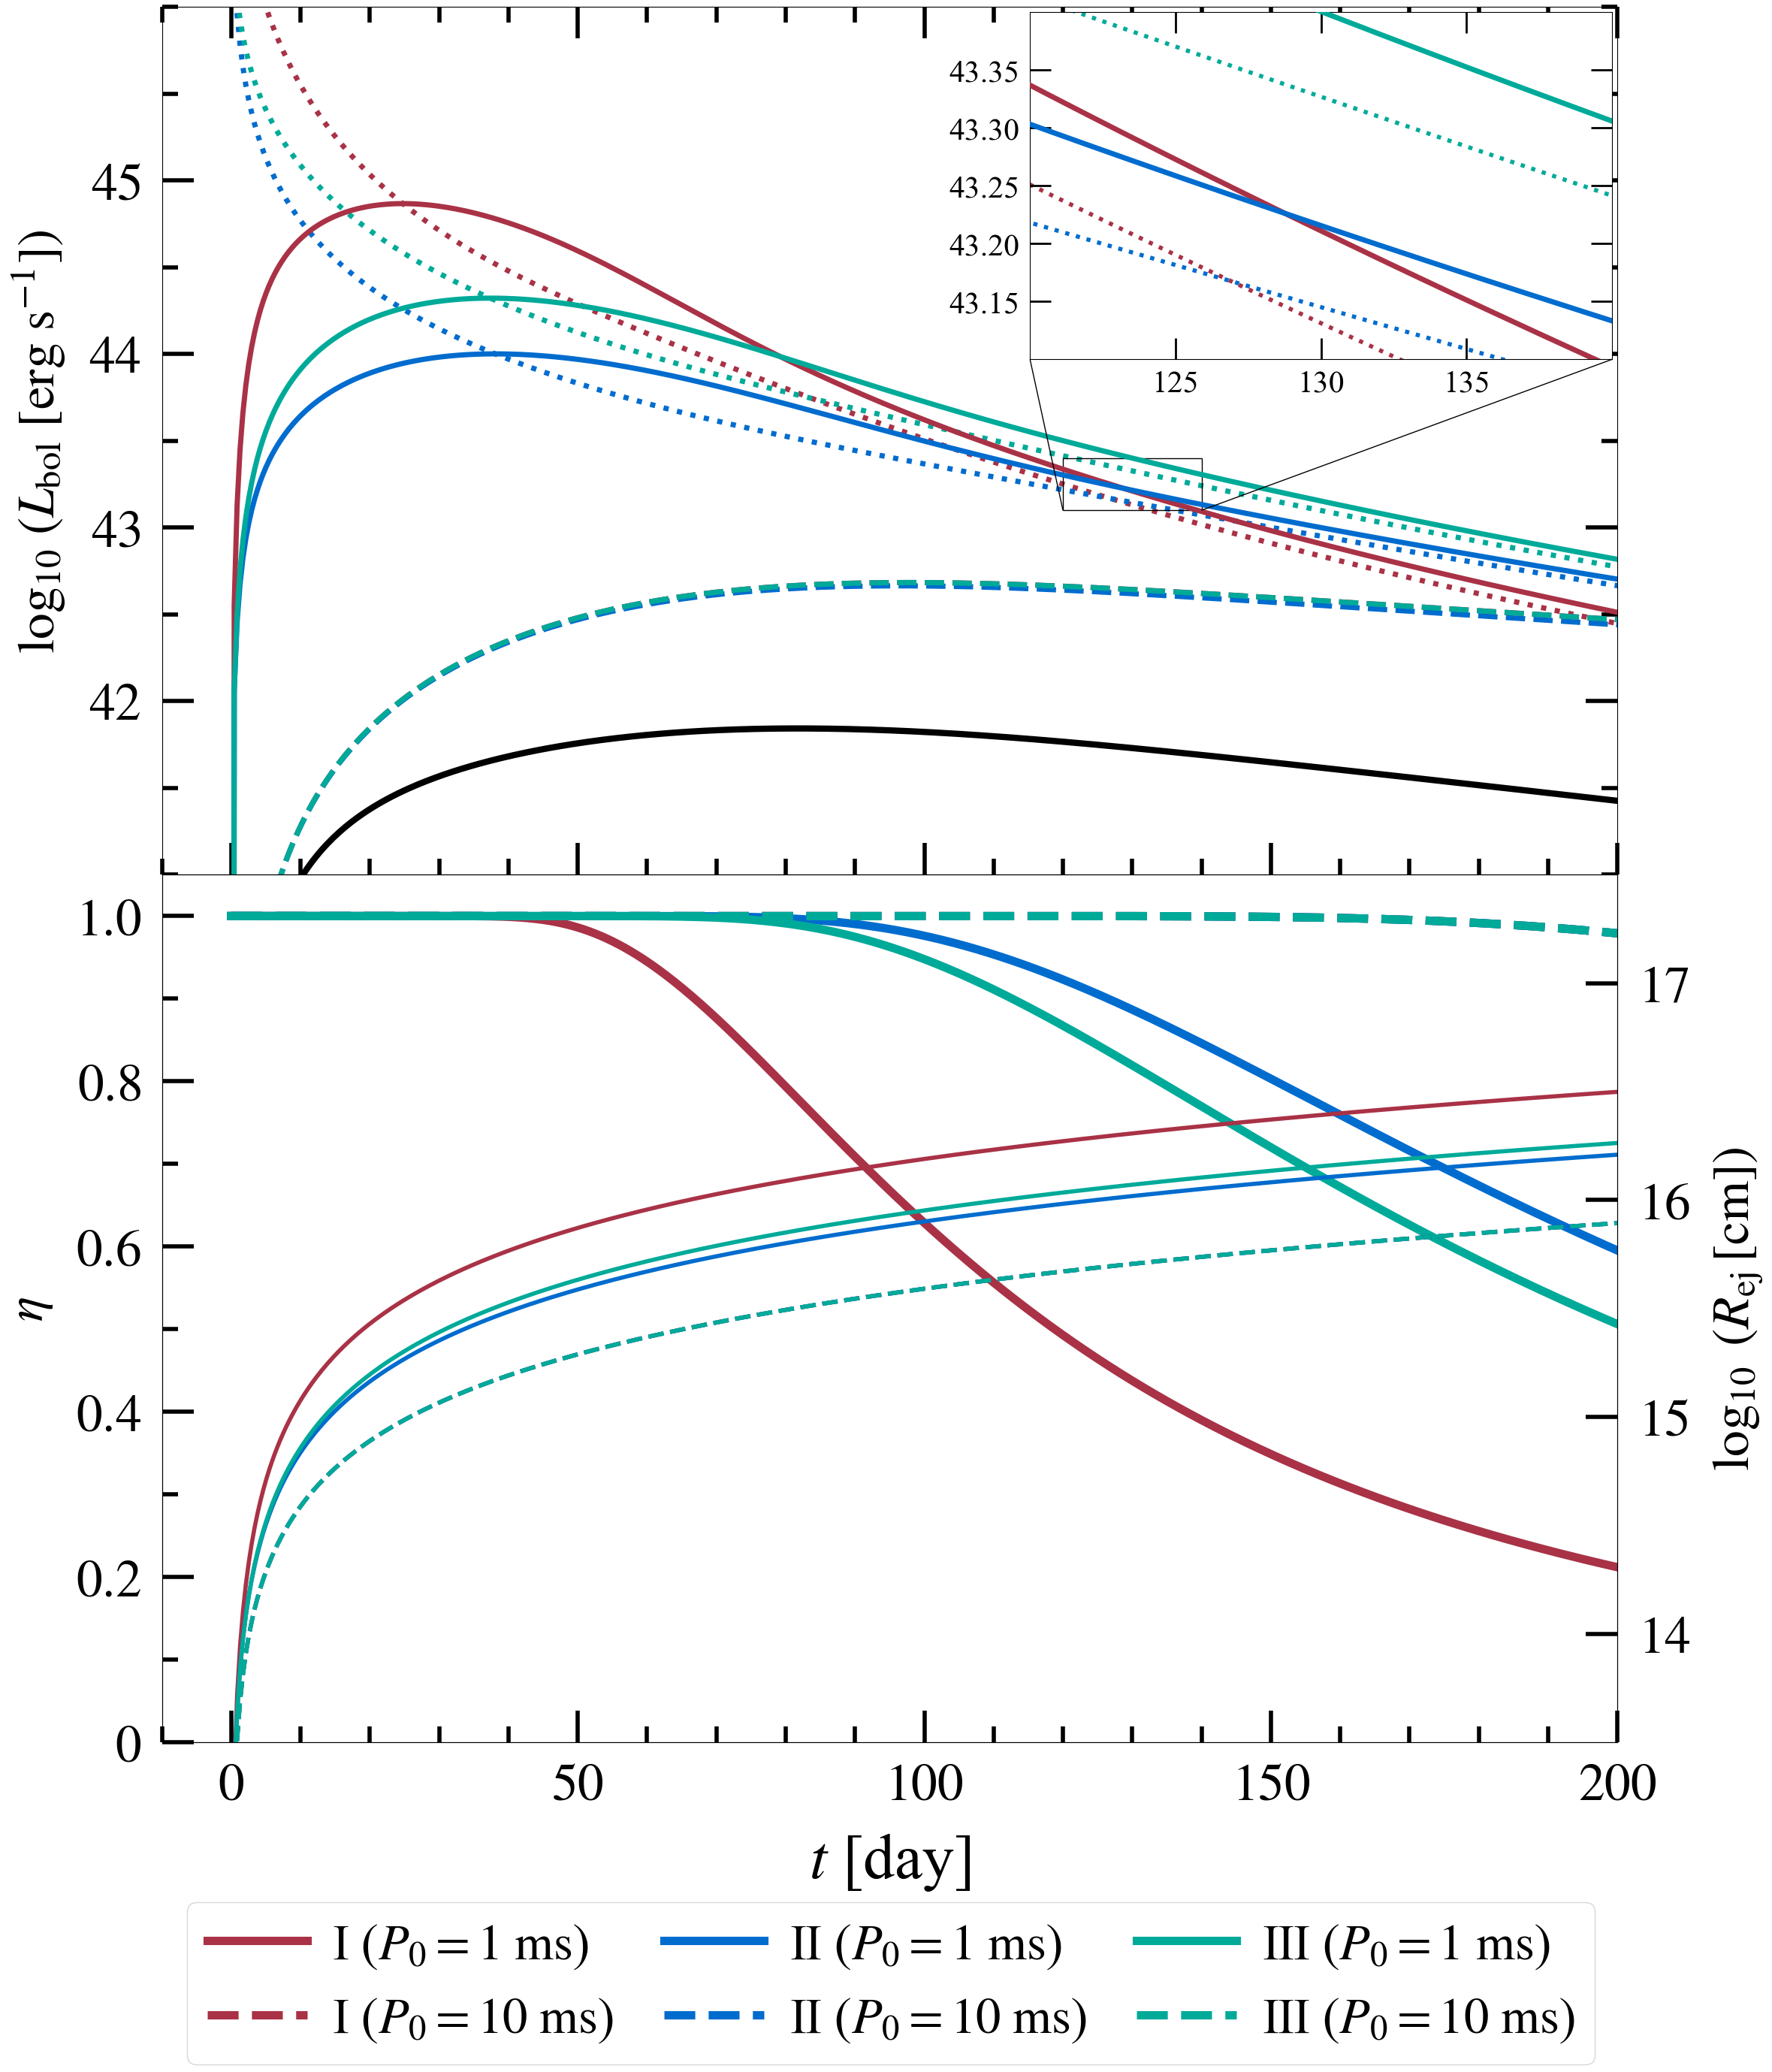

In [15]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# 设置画图的全局要求
plt.rcParams['font.family'] = 'Times New Roman'         # 文字字体
plt.rcParams['mathtext.fontset'] = 'stix'       # 数字字体
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'      # 刻度线朝向
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(30, 35))        # 创建 2 行 1 列的子图
fig.set_size_inches(25, 30)
ax3 = ax2.twinx()  # 创建子图 2 的右侧纵坐标
axins = inset_axes(ax1, width='40%', height='40%', loc='upper right')        # 创建小图

# 设置 xy 轴的取值范围
ax1.set_xlim(-10, 200)
ax1.set_ylim(41, 46)
ax2.set_ylim(0, 1.05)
ax3.set_ylim(13.5, 17.5)
# 设置 xy 轴的刻度间距
x_major_locator = MultipleLocator(50)
x_minor_locator = MultipleLocator(10)
ax1.xaxis.set_major_locator(x_major_locator)
ax1.xaxis.set_minor_locator(x_minor_locator)
y1_major_locator = MultipleLocator(1)
y1_minor_locator = MultipleLocator(0.5)
ax1.yaxis.set_major_locator(y1_major_locator)
ax1.yaxis.set_minor_locator(y1_minor_locator)
y2_major_locator = MultipleLocator(0.2)
y2_minor_locator = MultipleLocator(0.1)
ax2.yaxis.set_major_locator(y2_major_locator)
ax2.yaxis.set_minor_locator(y2_minor_locator)
y3_major_locator = MultipleLocator(0.2)
y3_minor_locator = MultipleLocator(1)
ax3.yaxis.set_major_locator(y3_major_locator)
ax3.yaxis.set_minor_locator(y3_minor_locator)
# 设置 xy 轴的标签以及刻度
ax2.set_xticks([0, 50, 100, 150, 200],
               [r'$0$', r'$50$', r'$100$', r'$150$', r'$200$'], size=50)
ax1.set_yticks([42, 43, 44, 45],
               [r'$42$', r'$43$', r'$44$', r'$45$'], size=50)
ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0],
               [r'$0$', r'$0.2$', r'$0.4$', r'$0.6$', r'$0.8$', r'$1.0$'], size=50)
ax3.set_yticks([14, 15, 16, 17], [r'$14$', r'$15$', r'$16$', r'$17$'], size=50)
ax2.set_xlabel(r'$t$ [day]', fontsize=60, labelpad=20)
ax1.set_ylabel(r'$\mathrm{log}_{10}~(L_\mathrm{bol} ~ [\mathrm{erg ~ s}^{-1}])$', fontsize=50, labelpad=20)
ax2.set_ylabel(r'$\eta$', fontsize=50, labelpad=20)
ax3.set_ylabel(r'$\log_{10}~(R_\mathrm{ej} \, [\mathrm{cm}])$', fontsize=50, labelpad=20)
ax1.tick_params(axis='both', which='major', length=30, width=4, pad=20, top=True, right=True)
ax1.tick_params(axis='both', which='minor', length=15, width=4, pad=20, top=True, right=True)
ax2.tick_params(axis='both', which='major', length=30, width=4, pad=20)
ax2.tick_params(axis='both', which='minor', length=15, width=4, pad=20)
ax3.tick_params(axis='both', which='major', length=30, width=4, pad=20)
ax3.tick_params(axis='both', which='minor', length=15, width=4, pad=20)
# 调整子图之间的间距
plt.subplots_adjust(hspace=0)

# 画图
style_list = ['-', '--']
color_list = ['#A93246', '#006CCE', '#00AA99']
P_0_list = [r'$P_0 = 1 \mathrm{~ms}$', r'$P_0 = 10 \mathrm{~ms}$']
t_plot = np.linspace(1e-3, 420*day, 10**3)
for i in range(len(type_list)):
    for j in range(len(Omega_0_list)):
        t_array, L_bol_array, eta_array, R_ej_array, L_inj_array = L_bol(type_list[i], 1e6, Omega_0_list[j])
        L_plot = interp1d(t_array, L_bol_array, kind='cubic', fill_value='extrapolate')
        eta_plot = interp1d(t_array, eta_array, kind='cubic', fill_value='extrapolate')
        R_plot = interp1d(t_array, R_ej_array, kind='cubic', fill_value='extrapolate')
        ax1.plot(t_plot / day, np.array([log(L_plot(i), 10) for i in t_plot]), label=f"{type_list[i]} ({P_0_list[j]})",
                 linestyle=style_list[j], color=color_list[i], linewidth=5, zorder=5)
        ax2.plot(t_plot / day, eta_plot(t_plot), label=f"{type_list[i]} ({P_0_list[j]})", linestyle=style_list[j], color=color_list[i],
                 linewidth=8)
        ax3.plot(t_plot / day, np.array([log(R_plot(i), 10) for i in t_plot]), linestyle=style_list[j], color=color_list[i],linewidth=4)
        if j == 0:
            axins.plot(t_plot / day, np.array([log(L_plot(i), 10) for i in t_plot]), label=f"{type_list[i]} ({P_0_list[j]})",
                 linestyle=style_list[j], color=color_list[i], linewidth=5, zorder=10)
            L_inj = interp1d(t_array, L_inj_array, kind='cubic', fill_value='extrapolate')
            ax1.plot(t_plot / day, np.array([log(L_inj(i), 10) for i in t_plot]),
                 linestyle=':', color=color_list[i], linewidth=5, zorder=0)
            axins.plot(t_plot / day, np.array([log(L_inj(i), 10) for i in t_plot]),
                 linestyle=':', color=color_list[i], linewidth=4, zorder=0)

t_array, L_rad_array = L_rad('EM', 1e6, Omega_0_list[0])
L_plot = interp1d(t_array, L_rad_array, kind='cubic', fill_value='extrapolate')
ax1.plot(t_plot / day, np.array([log(L_plot(i), 10) for i in t_plot]), color='k', linewidth=6)

# 设置小图的参数
axins.set_xlim(120, 140)
axins.set_ylim(43.1, 43.4)
axins.xaxis.set_major_locator(MultipleLocator(5))
axins.yaxis.set_major_locator(MultipleLocator(0.1))
axins.tick_params(axis='both', which='major', length=20, pad=10, top=True, right=True, width=2)
axins.set_xticks([125, 130, 135])
axins.set_yticks([43.15, 43.20, 43.25, 43.30, 43.35])
axins.set_xticklabels(['125', '130', '135'], fontsize=30)
axins.set_yticklabels(['43.15', '43.20', '43.25', '43.30', '43.35'], fontsize=30)
# 连接小图与大图
mark_inset(ax1, axins, loc1=3, loc2=4, fc="none", ec="k")

# ax1.legend(fontsize=30, loc='lower left')
ax2.legend(loc = 'lower left',
           bbox_to_anchor=(0, -0.4),
           fontsize = 48,
           ncol = 3,
           columnspacing = 1.0,
           handletextpad = 0.5)
plt.savefig('L_bol')
plt.savefig('L_bol.pdf', bbox_inches='tight')
plt.show()

# EoS

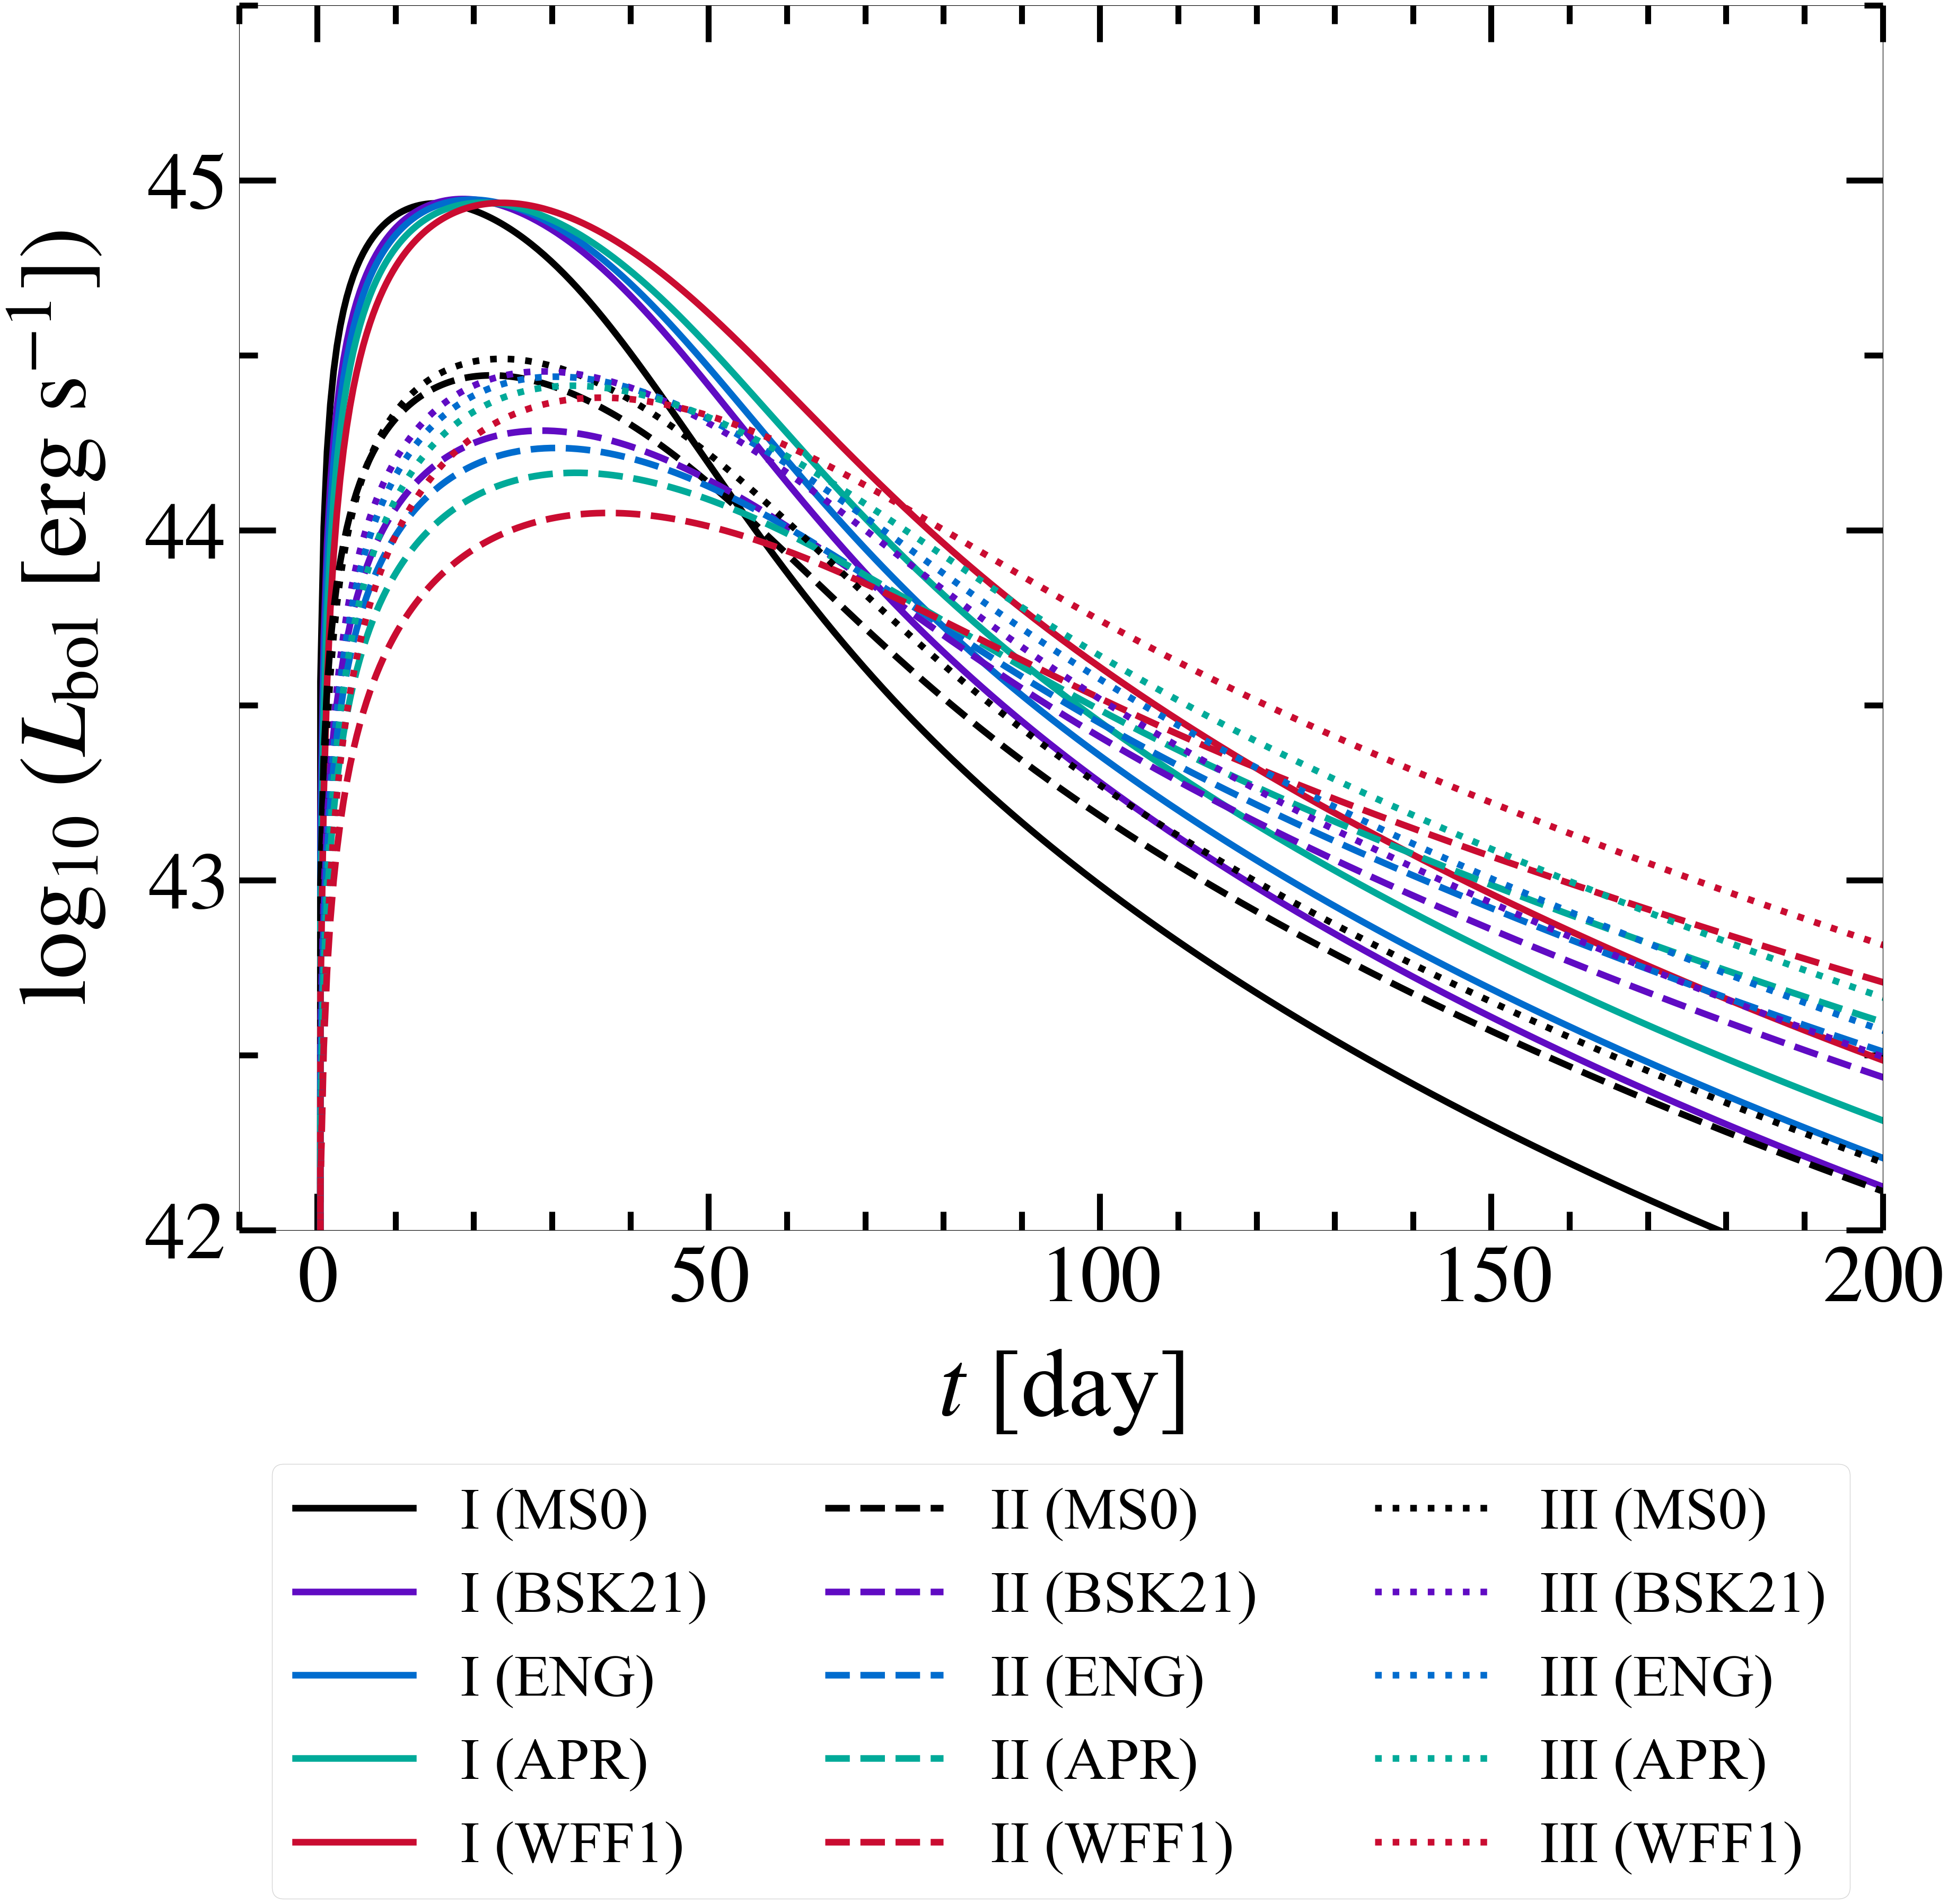

In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# 设置画图的全局要求
plt.rcParams['font.family'] = 'Times New Roman'         # 文字字体
plt.rcParams['mathtext.fontset'] = 'stix'       # 数字字体
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'      # 刻度线朝向
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))        # 创建图片
fig.set_size_inches(40, 30)

# 设置 xy 轴的取值范围
ax1.set_xlim(-10, 200)
ax1.set_ylim(42, 45.5)
# 设置 xy 轴的刻度间距
x_major_locator = MultipleLocator(50)
x_minor_locator = MultipleLocator(10)
ax1.xaxis.set_major_locator(x_major_locator)
ax1.xaxis.set_minor_locator(x_minor_locator)
y1_major_locator = MultipleLocator(1)
y1_minor_locator = MultipleLocator(0.5)
ax1.yaxis.set_major_locator(y1_major_locator)
ax1.yaxis.set_minor_locator(y1_minor_locator)
# 设置 xy 轴的标签以及刻度
ax1.set_xticks([0, 50, 100, 150, 200],
               [r'$0$', r'$50$', r'$100$', r'$150$', r'$200$'], size=110)
ax1.set_yticks([42, 43, 44, 45],
               [r'$42$', r'$43$', r'$44$', r'$45$'], size=110)
ax1.set_xlabel(r'$t$ [day]', fontsize=130, labelpad=40)
ax1.set_ylabel(r'$\mathrm{log}_{10}~(L_\mathrm{bol} ~ [\mathrm{erg ~ s}^{-1}])$', fontsize=130, labelpad=50)
ax1.tick_params(axis='both', which='major', length=50, width=8, pad=20, top=True, right=True)
ax1.tick_params(axis='both', which='minor', length=25, width=8, pad=20, top=True, right=True)

# 画图
style_list = ['-', '--', ':']
color_list = ['k', '#600BC3', '#006CCE', '#00AA99', '#CA0C31']
t_plot = np.linspace(1e-3, 420*day, 10**3)
for i in range(len(type_list)):
    for j in range(len(R_ns_list)):
        t_array, L_bol_array, eta_array, R_ej_array, L_inj_array = L_bol(type_list[i], R_ns_list[j], Omega_0_list[0], I=I_list[j])
        L_plot = interp1d(t_array, L_bol_array, kind='cubic', fill_value='extrapolate')
        ax1.plot(t_plot / day, np.array([log(L_plot(i), 10) for i in t_plot]), label=f"{type_list[i]} ({model_list[j]})", linestyle=style_list[i], color=color_list[j], linewidth=9)

ax1.legend(fontsize=80, ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.57))
plt.savefig('EoS', bbox_inches='tight')
plt.savefig('EoS.pdf', bbox_inches='tight')
plt.show()

# EoS差异

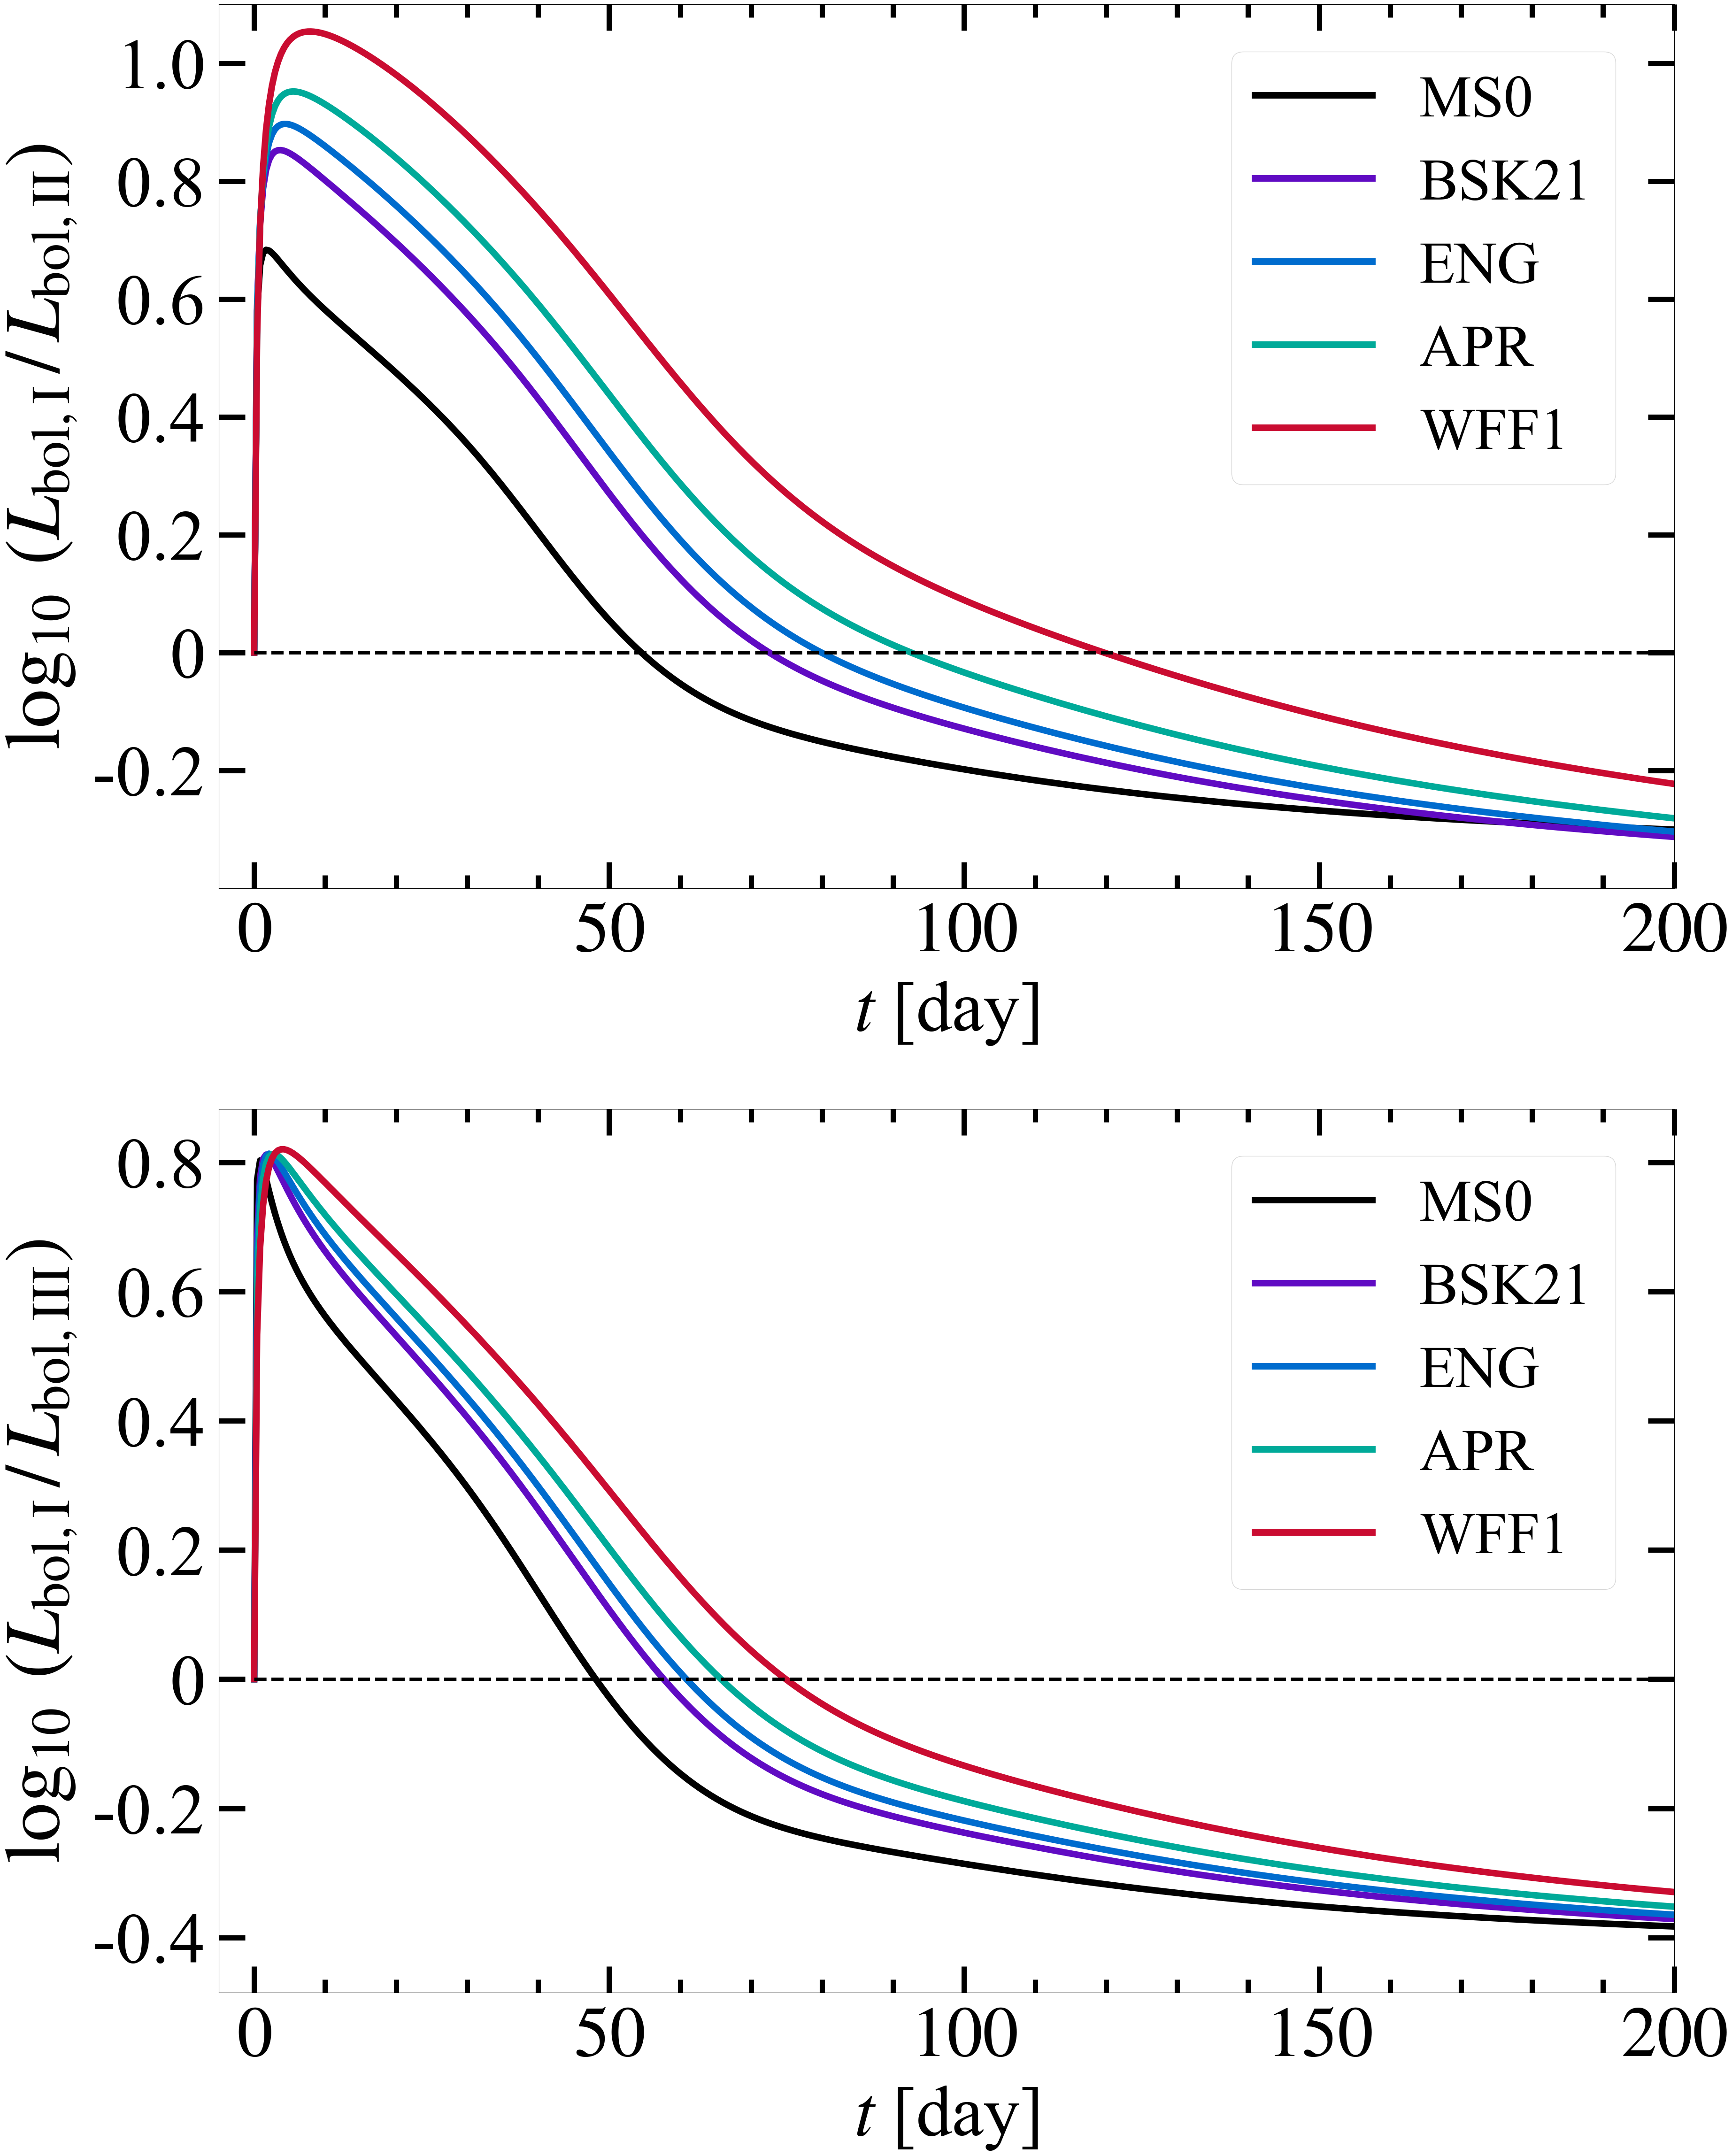

In [4]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# 设置画图的全局要求
plt.rcParams['font.family'] = 'Times New Roman'         # 文字字体
plt.rcParams['mathtext.fontset'] = 'stix'       # 数字字体
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'      # 刻度线朝向
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))        # 创建图片
fig.set_size_inches(40, 55)

# 设置 xy 轴的取值范围
ax1.set_xlim(-5, 200)
ax1.set_ylim(-0.4, 1.1)
# ax2.set_ylim(-0.15, 0.25)
# 设置 xy 轴的刻度间距
x_major_locator = MultipleLocator(50)
x_minor_locator = MultipleLocator(10)
ax1.xaxis.set_major_locator(x_major_locator)
ax1.xaxis.set_minor_locator(x_minor_locator)
ax2.xaxis.set_major_locator(x_major_locator)
ax2.xaxis.set_minor_locator(x_minor_locator)
y1_major_locator = MultipleLocator(0.2)
y1_minor_locator = MultipleLocator(0.1)
ax1.yaxis.set_major_locator(y1_major_locator)
# ax1.yaxis.set_minor_locator(y1_minor_locator)
y2_major_locator = MultipleLocator(0.2)
y2_minor_locator = MultipleLocator(0.1)
# 设置 xy 轴的标签以及刻度
ax1.set_xticks([0, 50, 100, 150, 200],
               [r'$0$', r'$50$', r'$100$', r'$150$', r'$200$'], size=110)
ax2.set_xticks([0, 50, 100, 150, 200],
               [r'$0$', r'$50$', r'$100$', r'$150$', r'$200$'], size=110)
ax1.set_yticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0],
               [-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0], size=110)
ax2.set_yticks([-0.4,-0.2, 0, 0.2, 0.4, 0.6, 0.8], [-0.4,-0.2, 0, 0.2, 0.4, 0.6, 0.8], size=110)
ax1.set_xlabel(r'$t$ [day]', fontsize=110, labelpad=20)
ax2.set_xlabel(r'$t$ [day]', fontsize=110, labelpad=20)
ax1.set_ylabel(r'$\log_{10} \; (L_\mathrm{bol,I} \, / \, L_\mathrm{bol,II})$', fontsize=120, labelpad=20)
ax1.tick_params(axis='both', which='major', length=40, width=8, pad=20, top=True, right=True, labelbottom=True)
ax1.tick_params(axis='x', which='minor', length=20, width=8, pad=20, top=True, right=True)
ax2.set_ylabel(r'$\log_{10} \; (L_\mathrm{bol,I} \, / \, L_\mathrm{bol,III})$', fontsize=120, labelpad=20)
ax2.tick_params(axis='both', which='major', length=40, width=8, pad=20, top=True, right=True)
ax2.tick_params(axis='x', which='minor', length=20, width=8, pad=20, top=True, right=True)
# 调整子图之间的间距
plt.subplots_adjust(hspace=0.25)

# 画图
color_list = ['k', '#600BC3', '#006CCE', '#00AA99', '#CA0C31']
t_plot = np.linspace(1e-3, 420*day, 10**3)
for j in range(len(R_ns_list)):
    t_array, L_EM_array, eta_array, R_ej_array, L_inj_array = L_bol(type_list[0], R_ns_list[j], Omega_0_list[0], I=I_list[j])
    t_array, L_GWe_array, eta_array, R_ej_array, L_inj_array = L_bol(type_list[1], R_ns_list[j], Omega_0_list[0], I=I_list[j])
    t_array, L_GWr_array, eta_array, R_ej_array, L_inj_array = L_bol(type_list[2], R_ns_list[j], Omega_0_list[0], I=I_list[j])
    L_1_plot = interp1d(t_array, L_EM_array / L_GWe_array, kind='cubic', fill_value='extrapolate')
    L_2_plot = interp1d(t_array, L_EM_array / L_GWr_array, kind='cubic', fill_value='extrapolate')
    ax1.plot(t_plot / day, np.array([log(L_1_plot(i), 10) for i in t_plot]),
             label=f"{model_list[j]}", linestyle=style_list[0], color=color_list[j], linewidth=10)
    ax2.plot(t_plot / day, np.array([log(L_2_plot(i), 10) for i in t_plot]),
             label=f"{model_list[j]}", linestyle=style_list[0], color=color_list[j], linewidth=10)
    ax1.plot(t_plot / day, np.zeros_like(t_plot), color='black',linestyle='--', linewidth=5)
    ax2.plot(t_plot / day, np.zeros_like(t_plot), color='black',linestyle='--', linewidth=5)

ax1.legend(fontsize=90, loc='upper right', ncol=1, bbox_to_anchor=(0.98, 0.98))
ax2.legend(fontsize=90, loc='upper right', ncol=1, bbox_to_anchor=(0.98, 0.98))
plt.savefig('difference')
plt.savefig('difference.pdf', bbox_inches='tight')
plt.show()